## Vehicle Detection Project

The goals / steps of this project are the following:
1. Extract image features like color and histogram of gradients
2. Build and train a classifier with a given data set
3. Searching for cars by using the trained classifier in a defined area applying the searching window technique
4. Remove multiple and false positive car detections
5. Create a pipeline to executes all the steps above
6. Run the pipeline to detect vehicles in a given video and output a new video showing the results.
7. Plot all the steps showing the approach of this project


## Import all packages

In [1]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import glob
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

## 1. Feature Extraction

### 1.1 Compute Color Features

In [2]:
##################################
# Extract color image features 
#################################


print ('Defining all functions for feature extraction...')

# Define a function for color features
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    
# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features   


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

Defining all functions for feature extraction...


### 1.2 Compute HOG Features

In [3]:
################################################
# Extract Histogram of gradients image features 
################################################

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


### 1.3 Combined Feature Extraction

In [4]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            # Apply bin_spatial() if spatial_feat==True
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist() if hist_feat==True
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis==False, feature_vec==True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


## 2. Train a Classifier
Build and train a classifier with a given data set

### 2.1 The Data Set

In [5]:
print ('Loading data for train an test classifier...')

car_list = glob.glob('vehicles/**/*.png')
noncar_list = glob.glob('non-vehicles/**/*.png')

#car_list = glob.glob('vehicles_smallset/**/*.jpeg')
#noncar_list = glob.glob('non-vehicles_smallset/**/*.jpeg')

print ('Loading is DONE')

# Define a function to return some characteristics of the dataset 
def data_look(car_list, noncar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_noncars"] = len(noncar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    return data_dict
    
data_info = data_look(car_list, noncar_list)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_noncars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])



Loading data for train an test classifier...
Loading is DONE
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


### 2.2 Set Parameter

In [6]:
print ('Set parameter for train an test the classifier...')

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

print ('Seting parameter is DONE')

Set parameter for train an test the classifier...
Seting parameter is DONE


### 2.3 extract features for classifier

In [7]:
print ('Extracting features for classifier...')

t=time.time()

car_features = extract_features(car_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
noncar_features = extract_features(noncar_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print ('Extracting is DONE')

t2=time.time()
print(round(t2-t,2), 'Seconds to extract HOG features...')

Extracting features for classifier...
Extracting is DONE
320.49 Seconds to extract HOG features...


### 2.4 Set up Training Data

In [8]:
print ('Set up training data...')

X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print ('Seting up training data is DONE')

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell', cell_per_block,'cells per block',
     hist_bins,'histogram bins, and', spatial_size,'spacial sampling')
print('Feature vector length:', len(X_train[0]))

print ('Set up is DONE')

Set up training data...
Seting up training data is DONE
Using: 9 orientations 8 pixels per cell 2 cells per block 32 histogram bins, and (32, 32) spacial sampling
Feature vector length: 8460
Set up is DONE


### 2.5 Create and Run the Classifier

In [9]:
# Use a linear SVC 
svc = LinearSVC()
print ('Classifier is created')

# Check the training time for the SVC
t=time.time()
print ('Training is running...')
svc.fit(X_train, y_train)
print ('Training is DONE')
t2 = time.time()

# print results
print(round(t2-t, 2), 'Seconds to train SVC')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Classifier is created
Training is running...
Training is DONE
485.93 Seconds to train SVC
Test Accuracy of SVC =  0.993


### 2.6 Save Classifier Parameters

In [10]:
# Save data to pickle file
print('Saving Classifier parameters to file...')

dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, open("svc_pickle.p", 'wb') )

print('Saving is DONE')

Saving Classifier parameters to file...
Saving is DONE


## 3. Detect Cars

In [11]:
###############################################################################################################
# Searching for cars by using the trained classifier in a defined area applying the searching window technique
###############################################################################################################

# Define a single function that can extract features using hog sub-sampling and make predictions 
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bbox_list=[]
    
   
    draw_img = np.copy(img)
    plot_img_1 = np.copy(img)
    plot_img_2 = np.copy(img)
    plot_img_3 = np.copy(img)
    
    img = img.astype(np.float32)/255
    # Multi-Scale Windows:    
    ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
    # ystart: start y coordinate to define region of interest
    # ystop: end y coordinate to definde area of interest
    # scale: scale for overlapping between searching windows
    i = 0
    
    for (ystart, ystop, scale) in ystart_ystop_scale:
        i = i+1        
        img_tosearch = img[ystart:ystop, :, :]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        
       
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell
                
                
                if i == 1:
                    #for plotting all searching windows in the first multi scale area
                    xbox_left_1 = np.int(xleft*scale)
                    ytop_draw_1 = np.int(ytop*scale)
                    win_draw_1 = np.int(window*scale)

                    x_top_left = xbox_left_1
                    y_top_left = ytop_draw_1+ystart
                    x_bottom_right = xbox_left_1+win_draw_1
                    y_bottom_right = ytop_draw_1+win_draw_1+ystart
                    
                    plot_img_1 = cv2.rectangle(plot_img_1,(x_top_left, y_top_left),(x_bottom_right, y_bottom_right), (0,0,255), 5) 
                    
                    
                if i == 2:
                    #for plotting all searching windows in the second multi scale area
                    xbox_left_2 = np.int(xleft*scale)
                    ytop_draw_2 = np.int(ytop*scale)
                    win_draw_2 = np.int(window*scale)

                    x_top_left = xbox_left_2
                    y_top_left = ytop_draw_2+ystart
                    x_bottom_right = xbox_left_2+win_draw_2
                    y_bottom_right = ytop_draw_2+win_draw_2+ystart

                    plot_img_2 = cv2.rectangle(plot_img_2,(x_top_left, y_top_left),(x_bottom_right, y_bottom_right), (0,0,255), 5) 

                if i == 3:
                    #for plotting all searching windows in the third multi scale area
                    xbox_left_3 = np.int(xleft*scale)
                    ytop_draw_3 = np.int(ytop*scale)
                    win_draw_3 = np.int(window*scale)

                    x_top_left = xbox_left_3
                    y_top_left = ytop_draw_3+ystart
                    x_bottom_right = xbox_left_3+win_draw_3
                    y_bottom_right = ytop_draw_3+win_draw_3+ystart

                    plot_img_3 = cv2.rectangle(plot_img_3,(x_top_left, y_top_left),(x_bottom_right, y_bottom_right), (0,0,255), 5) 

                
                

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart), (0,0,255), 6) 
                    bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return draw_img, bbox_list, plot_img_1, plot_img_2, plot_img_3



## 4. Multiple Detections & False Positives

In [12]:
####################################################
# Remove multiple and false positive car detections
###################################################

# Define a function to add a heat to each box in bbox_list
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# Define a functio to apply a threshold to help remove false positives    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Define function to draw final labels from heatmap 
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Class for saving last hot labels from last N frames using queue
class LabelMemory():
    def __init__ (self):
        # Number labels to store
        self.queue_len = 10 
        self.queue = []

    # Put new frame
    def put_labels(self, labels):
        if (len(self.queue) > self.queue_len):
            tmp = self.queue.pop(0)
        self.queue.append(labels)
    
    # Get last N frames hot boxes
    def get_labels(self):
        b = []
        for label in self.queue:
            b.extend(label)
        return b

## 5. Pipeline

### 5.1 Loading Classifier Parameter for Pipeline

In [13]:
print('Loading Classifier parameters...')


dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

print('Loading is DONE')

Loading Classifier parameters...
Loading is DONE


### 5.2 Define Pipeline

In [14]:
#####################################################
# Create a pipeline to executes all the steps above
#####################################################

# Define pipeline for vehicle detection

def pipeline(img):
    draw_img, bbox_list, plot_img_1, plot_img_2, plot_img_3 = find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    LastHotLabels.put_labels(bbox_list)
    bbox_final = LastHotLabels.get_labels()

    heat = add_heat(heat,bbox_final)
    heatmap = apply_threshold(heat, 10)
    heatmap = np.clip(heatmap, 0, 255)
    labels = label(heatmap)
    text_img = img.copy()
    cv2.putText(text_img, 'Detected Cars: {} ' .format(labels[1]), (400, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 4)

    draw_img = draw_labeled_bboxes(np.copy(text_img), labels)
   
    return draw_img


In [15]:
# Define pipeline for testing and plots

def pipeline_test(img):
    draw_img_all, bbox_list, plot_img_1, plot_img_2, plot_img_3 = find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    
    
    # Draw all searching windows
    plt.figure(figsize=(4, 3))
    plt.title('First Multi-Scale Window', fontsize=17)
    plt.imshow(plot_img_1)
    plt.savefig('output_images/FirstMSW.jpg')
    plt.show()
    
    plt.figure(figsize=(4, 3))
    plt.title('Second Multi-Scale Window', fontsize=17)
    plt.imshow(plot_img_2)
    plt.savefig('output_images/SecondMSW.jpg')
    plt.show()
    
    plt.figure(figsize=(4, 3))
    plt.title('Third Multi-Scale Window', fontsize=17)
    plt.imshow(plot_img_3)
    plt.savefig('output_images/ThirdMSW.jpg')
    plt.show()
    
    f,(ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(40,10))
    ax1.imshow(plot_img_1)
    ax1.set_title('First Multi-Scale Window', fontsize=17)
    ax2.imshow(plot_img_2)
    ax2.set_title('Second Multi-Scale Window ', fontsize=17)
    ax3.imshow(plot_img_3)
    ax3.set_title('Third Multi-Scale Window ', fontsize=17)    
    plt.savefig('output_images/MS_Windows.jpg')
    plt.show()
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    heat = add_heat(heat,bbox_list)
    heatmap = apply_threshold(heat, 3)
    heatmap = np.clip(heatmap, 0, 255)
    labels = label(heatmap)
    text_img = img.copy()
    cv2.putText(text_img, 'Detected Cars: {} ' .format(labels[1]), (400, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 4)

    draw_img = draw_labeled_bboxes(np.copy(text_img), labels)
    
   
    # Draw steps of removing false positives and multiple windows
    plt.figure(figsize=(4, 3))
    plt.title('Heat Map', fontsize=17)
    plt.imshow(heatmap, cmap='hot')
    plt.savefig('output_images/HeatMap.jpg')
    plt.show()
    
    plt.figure(figsize=(4, 3))
    plt.title('Heat Map Binary', fontsize=17)
    plt.imshow(labels[0], cmap='gray')
    plt.savefig('output_images/HeatMapBinary.jpg')
    plt.show()
    
    plt.figure(figsize=(4, 3))
    plt.title('All Detections', fontsize=17)
    plt.imshow(draw_img_all)
    plt.savefig('output_images/AllDetectionSmall.jpg')
    plt.show()
    
    f,(ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(40,10))
    ax1.imshow(draw_img_all)
    ax1.set_title('All Detections', fontsize=17)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Heat Map', fontsize=17)
    ax3.imshow(labels[0], cmap='gray')
    ax3.set_title('Heat Map Binary', fontsize=17)
    plt.savefig('output_images/NoFalseOrMultiple.jpg')
    plt.show()
   
    # Draw image of all the vehicle detection
    plt.figure(figsize=(20, 12))
    plt.title('All Detections', fontsize=30)
    plt.imshow(draw_img_all)
    plt.savefig('output_images/AllDetection.jpg')
    plt.show()

   
    # Draw result image of vehicle detection
    plt.figure(figsize=(20, 12))
    plt.imshow(draw_img)
    plt.title('Visual Output of the final Car Detection', fontsize=30)
    plt.savefig('output_images/FinalCarDetection.jpg')
    plt.show()

## 6. Creating the Video

In [16]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
#imageio.plugins.ffmpeg.download import ffmpeg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
###################################################################################################
# Run the pipeline to detect vehicles in a given video and output a new video showing the results.
###################################################################################################

LastHotLabels = LabelMemory()
result_video = 'result_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
result_clip = clip1.fl_image(lambda img: pipeline(img))
%time result_clip.write_videofile(result_video, audio=False)


[MoviePy] >>>> Building video result_video.mp4
[MoviePy] Writing video result_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [40:06<00:01,  1.94s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_video.mp4 

Wall time: 40min 10s


## 7. Playground for plots

### 7.1 Defining plot functions

In [18]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0,200), (0, 200), (0, 200)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


def color_hist_plot(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    Yhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    Crhist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    Cbhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = Yhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((Yhist[0], Crhist[0], Cbhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return Yhist, Crhist, Cbhist, bin_centers

### 7.2 Define Images for plots

In [19]:
# Define car and non-car images out of Data Set
################################################
# Read in images
car_image = mpimg.imread('vehicles/GTI_MiddleClose/image0038.png')
noncar_image = mpimg.imread('non-vehicles/GTI/image13.png')


# Define an image out of Video frame
#####################################
# read a test image 
road_image = mpimg.imread('test_images/test4.jpg')


### 7.2 Plot Output

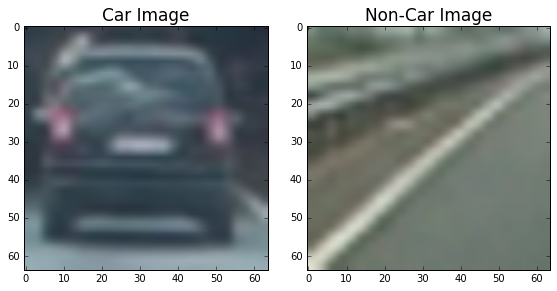

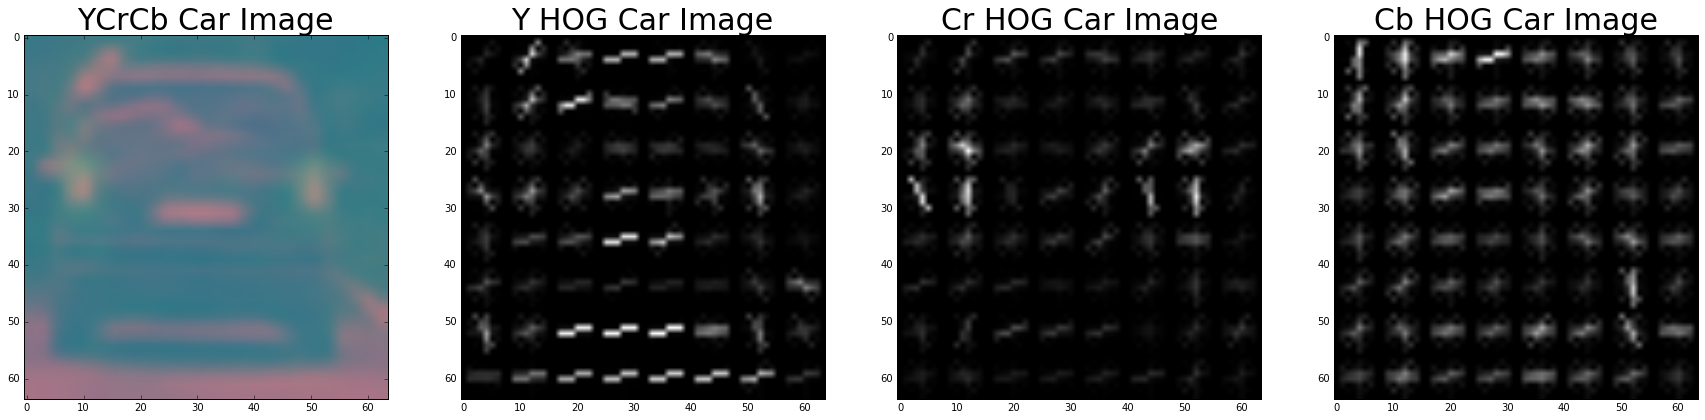

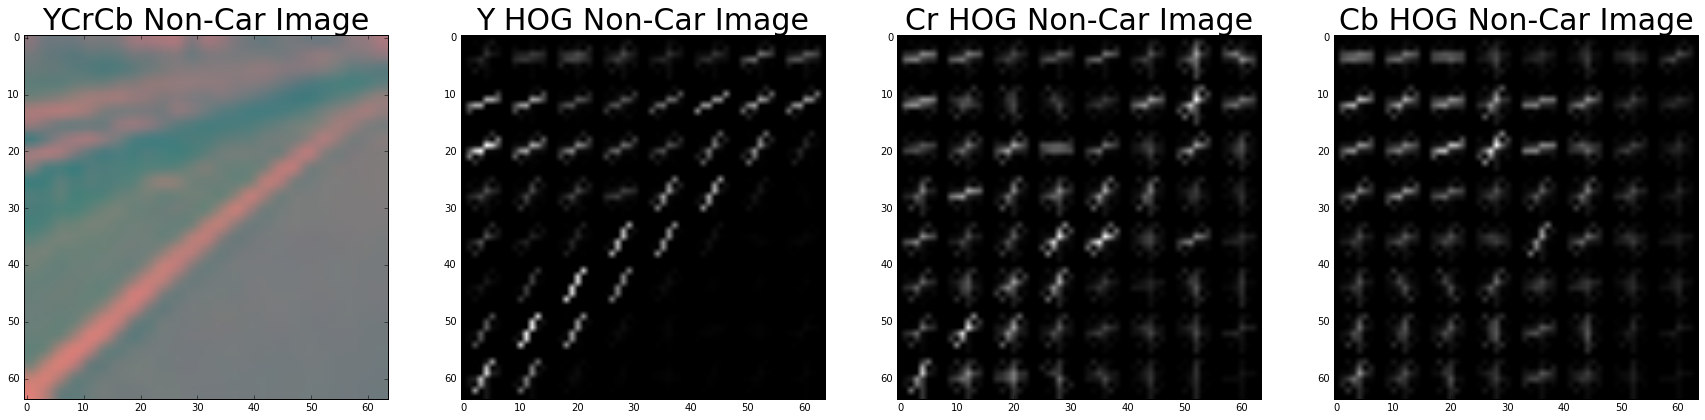

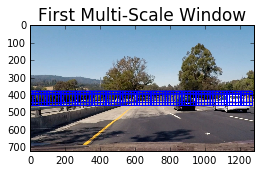

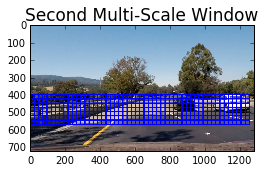

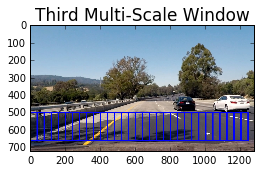

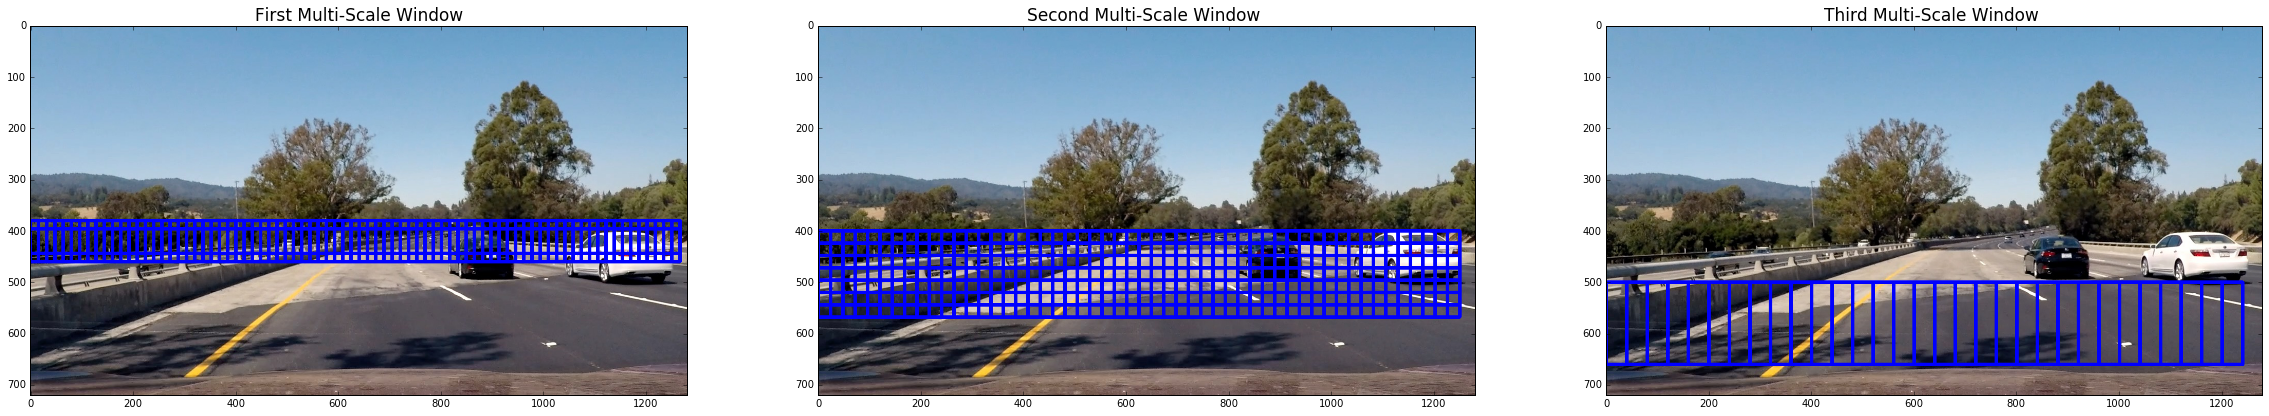

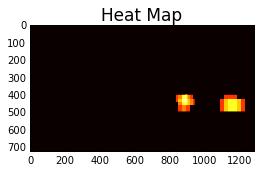

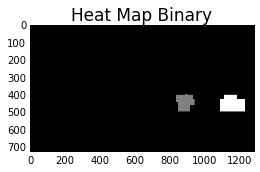

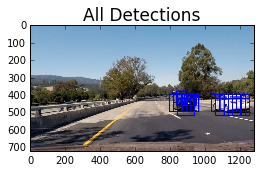

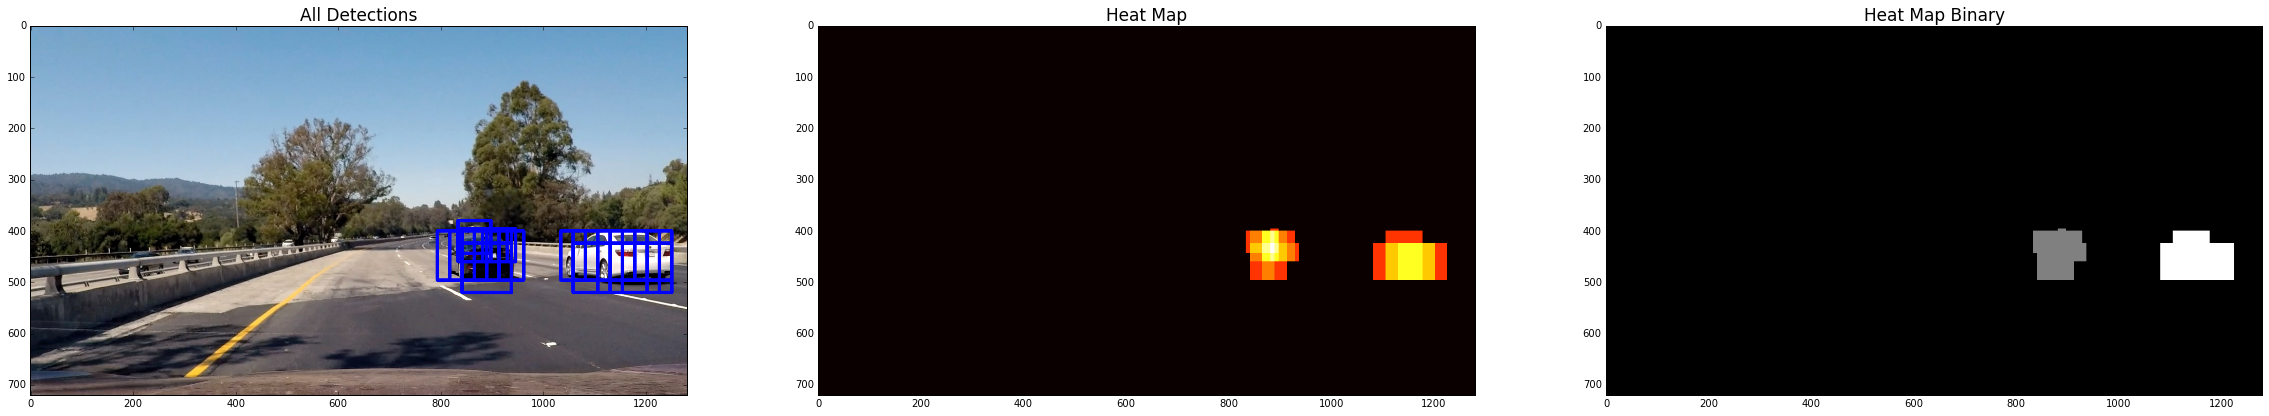

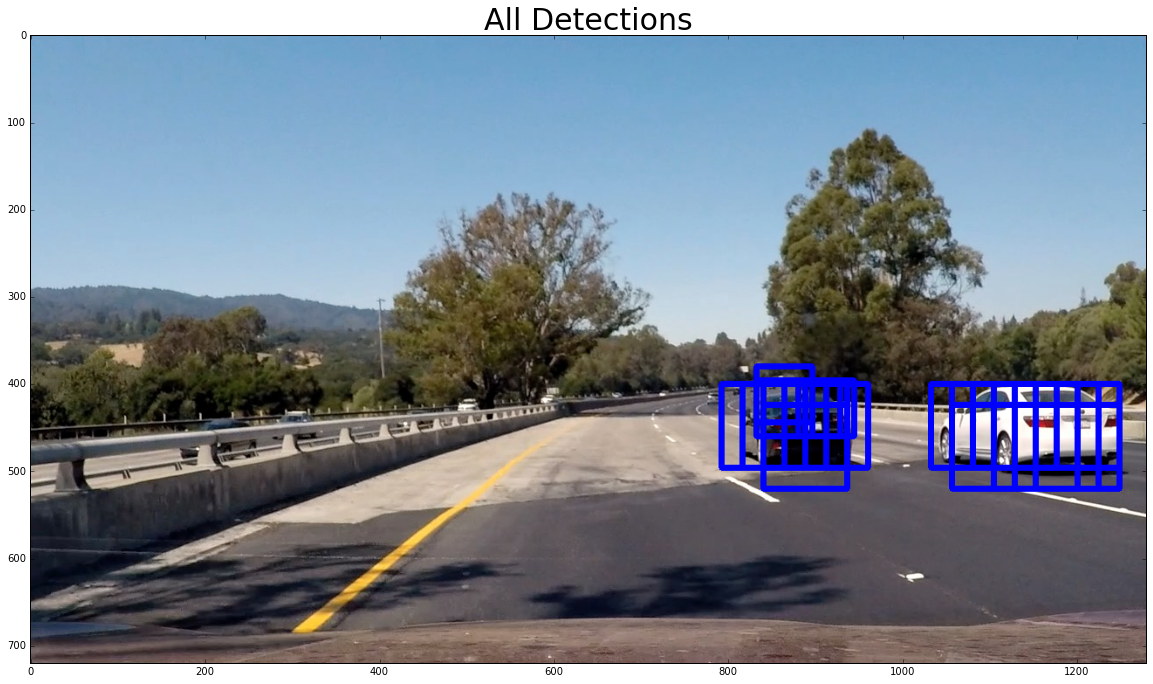

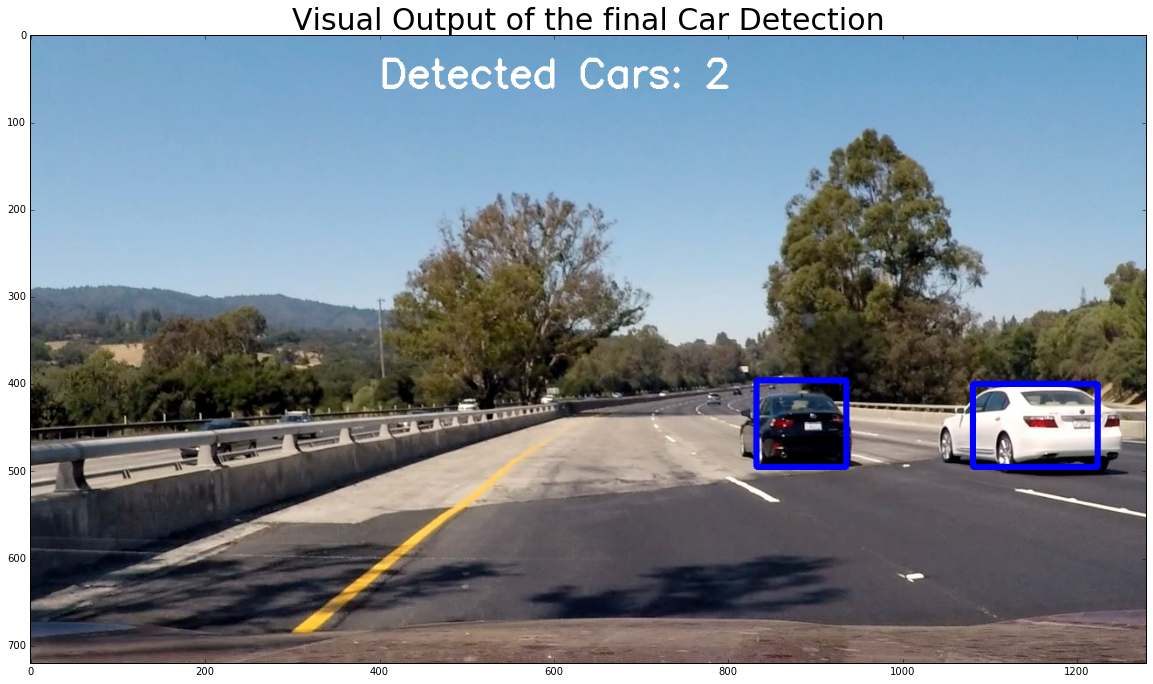

In [20]:
##########################################################
# Plot all the steps showing the approach of this project
###########################################################



# Original Car and Non-Car Image Example
#########################################
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
f.tight_layout()
ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=17)
ax2.imshow(noncar_image)
ax2.set_title('Non-Car Image', fontsize=17)
plt.savefig('output_images/OriginalCarNonCar.jpg')
plt.show()


# HOG Figure
#################
car_YCrCb = convert_color(car_image, conv='RGB2YCrCb')
noncar_YCrCb = convert_color(noncar_image, conv='RGB2YCrCb')

Y_car = car_YCrCb[:,:,0]
Cr_car = car_YCrCb[:,:,1]
Cb_car = car_YCrCb[:,:,2]

Y_noncar = noncar_YCrCb[:,:,0]
Cr_noncar = noncar_YCrCb[:,:,1]
Cb_noncar = noncar_YCrCb[:,:,2]

#Produce HOG Channel outputs
car_features,car_hogimg_Y = get_hog_features(Y_car, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
noncar_features,noncar_hogimg_Y = get_hog_features(Y_noncar, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
car_features,car_hogimg_Cr = get_hog_features(Cr_car, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
noncar_features,noncar_hogimg_Cr = get_hog_features(Cr_noncar, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
car_features,car_hogimg_Cb = get_hog_features(Cb_car, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
noncar_features,noncar_hogimg_Cb = get_hog_features(Cb_noncar, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)



# HOG Figure with Image Example
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(30,8))
ax1.imshow(car_YCrCb)
ax1.set_title('YCrCb Car Image', fontsize=30)
ax2.imshow(car_hogimg_Y, cmap='gray')
ax2.set_title('Y HOG Car Image', fontsize=30)
ax3.imshow(car_hogimg_Cr, cmap='gray')
ax3.set_title('Cr HOG Car Image', fontsize=30)
ax4.imshow(car_hogimg_Cb, cmap='gray')
ax4.set_title('Cb HOG Car Image', fontsize=30)
plt.savefig('output_images/HOG_Car.jpg')
plt.show()


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(30,8))
ax1.imshow(noncar_YCrCb)
ax1.set_title('YCrCb Non-Car Image', fontsize=30)
ax2.imshow(noncar_hogimg_Y, cmap='gray')
ax2.set_title('Y HOG Non-Car Image', fontsize=30)
ax3.imshow(noncar_hogimg_Cr, cmap='gray')
ax3.set_title('Cr HOG Non-Car Image', fontsize=30)
ax4.imshow(noncar_hogimg_Cb, cmap='gray')
ax4.set_title('Cb HOG Non-Car Image', fontsize=30)
plt.savefig('output_images/HOG_NonCar.jpg')
plt.show()


# Plot all searching windows including multiscaling
# Plot steps of removing Multiple Detections & False Positives
# Plot the result of vehicle detection
##############################################################

pipeline_test(road_image)

